In [0]:
pip install deap

     |████████████████████████████████| 153kB 4.8MB/s 


In [0]:
from google.colab import drive

drive.mount('/gdrive')
gdrive_root = '/gdrive/My Drive'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [0]:
import torch.nn as nn

class Generator(nn.Module):
    def __init__(self, ngpu, nc, nz, ngf):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(nz, ngf * 8, 7, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 7 x 7
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 3, 1, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 7 x 7
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 14 x 14
            nn.ConvTranspose2d(ngf * 2, ngf, 3, 1, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 14 x 14
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 28 x 28
        )

    def forward(self, input):
        return self.main(input)

In [140]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.utils as utils
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import numpy as np
from matplotlib import pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

def imshow(img):
    img = (img + 1) / 2
    img = img.squeeze()
    np_img = img.numpy()
    plt.imshow(np_img, cmap='gray')
    plt.show()

def imshow_grid(img):
    img = utils.make_grid(img.cpu().detach())
    img = (img + 1) / 2
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Hyper parameters
params = {
    'input_size': 28,  # image size 1x64x64
    'batch_size': 64,  # batch size
    'pop_size': 100,   # population size
    'nc': 1,  # number of channels
    'nz': 100,  # size of z latent vector
    'ngf': 64,  # size of feature maps in generator
    'ndf': 32,  # size of feature maps in discriminator
    'num_epochs': 1000,  # number of epochs
    'lr': 0.0001,  # learning rate
    'beta1': 0.5,   # beta1 for adam optimizer
    'ngpu': 1,  # number of GPU
    'lambda_gp': 10,  # loss weight for gradient penalty
    'n_critic': 5,
}

#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Generator(ngpu, nc, nz, ngf)
# 이 부분에서 체크포인트 위치 설정.
netG = Generator(params['ngpu'], params['nc'], params['nz'], params['ngf'])
netG.load_state_dict(torch.load(gdrive_root + '/checkpoints/netG_12500.pth', map_location=torch.device('cpu')))

# transform
transform = transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize(mean=(0.5,), std=(0.5,))])

#transform = transforms.Compose([transforms.ToTensor()])
# data sets and data loader
train_data = datasets.MNIST(root='data/', train=True, transform=transform, download=True)
train_data_loader = DataLoader(train_data, params['batch_size'], shuffle=False)
first_batch = train_data_loader.__iter__().__next__()  # first batch of MNIST data set : torch.Size([64x, 1, 28, 28])
print(first_batch[0][0].shape)  # torch.Size([1, 28, 28])
#imshow(first_batch[0][0])  # plot the image of first batch

torch.Size([1, 28, 28])


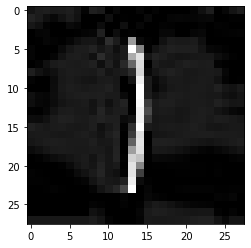

torch.Size([1, 28, 28])


In [141]:
from PIL import Image
import torchvision.transforms.functional as TF

my_image = Image.open(gdrive_root + '/my_data/0.1_1to7.jpg')
my_x = TF.to_tensor(my_image)

imshow(my_x)
print(my_x.size())

In [0]:
# Input image for defense GAN
# For the test purpose, we will use MNIST data sample first.
# fgsm_image : torch.Size([1, 28, 28]). This is image x.
fgsm_image = first_batch[0][0]  # torch.Size([1, 28, 28]). This should be fgsm_image later on.
#fgsm_image = my_x
# evalFunc 에서 numpy 형태로 계산하려고 모양 수정 / 일단은 그냥 28, 28로 했는데 나중엔 일렬로 계산해도 될 듯.
x = fgsm_image.view(28,28).numpy()
#imshow(fgsm_image)

# individual은 numpy array
# numpy array 가 들어오면 -> tensor로 바꾸고, netG input 모양에 맞춰줌.
# netG의 output이 tensor 형태이므로, numpy로 바꿔서 계산.. (이부분 텐서 형태에서 계산으로 추후 수정하면 될 듯.)
def evalFunc(individual):
    individual = torch.from_numpy(individual).view(1, 100, 1, 1)
    #temp = transforms.Normalize(0.5, 0.5)(netG(individual).view(28, 28))
    return np.linalg.norm(netG(individual).view(28, 28).detach().numpy() - x, ord=2)**2,

# Initial population for GA
# initial_population : torch.Size([100, 100, 1, 1]), This has 100 latent vectors z (z is torch.Size([100, 1, 1])).
# for example, initial_population[0] is z_0, initial_population[1] is z_1, ..., initial_population[99] is z_99.
initial_population = torch.FloatTensor(params['pop_size'], params['nz'], 1, 1).normal_(0, 1)
#print(initial_population.shape)  # torch.Size([100, 100, 1, 1])


# 이 부분은 evalFunc 이 잘 작동하는지 확인하는 부분입니당.
# z 가 길이 100짜리 1차원 numpy array 라고 가정하고(GA 에서 기본 individual 형태) evalFunc에 넣은뒤, 출력
# z = torch.FloatTensor(1, params['nz'], 1, 1).normal_(0, 1)
# z = z.view(100).numpy()
# print(evalFunc(z))

# initial_population를 numpy로 타입 맞춰주기.
initial_population = initial_population.view(100, 100).numpy()

def initIndividual(icls, content):
  return icls(content)

def initPopulation(pcls, ind_init):
  return pcls(ind_init(c) for c in initial_population)

In [143]:
import random
from deap import creator, base, tools, algorithms

# TOCHECK:  will we use algorithm modules?

'''
Fitness : single optimization, minimize ||G(z) - x||^2_2
'''
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", np.ndarray, fitness=creator.FitnessMin) # minimizing the fitness value

toolbox = base.Toolbox()

'''
[HYPERPARAMETERS]
List of Floats: individuals composed of 'IND_SIZE' floating point numbers
IND_SIZE: z의 dimension으로 보면 될듯
POPULATION
CXPB: probability of crossover
MUTPB: probability of mutation
'''
IND_SIZE = 100
POPULATION = 100
CXPB, MUTPB = 0.2, 0.6
GENERATIONS = 5000

toolbox.register("attr_float", random.random)
# toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, n=IND_SIZE)
toolbox.register("individual", initIndividual, creator.Individual)
toolbox.register("population", initPopulation, list, toolbox.individual)

/usr/local/lib/python3.6/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.6/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


In [0]:
def cxTwoPointCopy(ind1, ind2):
    """Execute a two points crossover with copy on the input individuals. The
    copy is required because the slicing in numpy returns a view of the data,
    which leads to a self overwritting in the swap operation. It prevents
    ::
    
        >>> import numpy
        >>> a = numpy.array((1,2,3,4))
        >>> b = numpy.array((5,6,7,8))
        >>> a[1:3], b[1:3] = b[1:3], a[1:3]
        >>> print(a)
        [1 6 7 4]
        >>> print(b)
        [5 6 7 8]
    """
    size = len(ind1)
    cxpoint1 = random.randint(1, size)
    cxpoint2 = random.randint(1, size - 1)
    if cxpoint2 >= cxpoint1:
        cxpoint2 += 1
    else: # Swap the two cx points
        cxpoint1, cxpoint2 = cxpoint2, cxpoint1

    ind1[cxpoint1:cxpoint2], ind2[cxpoint1:cxpoint2] \
        = ind2[cxpoint1:cxpoint2].copy(), ind1[cxpoint1:cxpoint2].copy()
        
    return ind1, ind2

In [0]:
'''
Evaluation Function: ||G(z) - x||^2_2 <- use 'np.linalg.norm( , ord=2)**2'
'''
# TODO : need to change mate, mutate, select operator
# can check in here : https://deap.readthedocs.io/en/master/api/tools.html
toolbox.register("evaluate", evalFunc)
toolbox.register("mate", cxTwoPointCopy)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=0.5, indpb=0.8)
toolbox.register("select", tools.selTournament, tournsize=3)

In [0]:
def main():
    random.seed(777)

    # pop = toolbox.population(n=POPULATION)
    pop = toolbox.population()
    
    print("Start of evolution")

    # Evaluate the entire population
    # print(fitnesses) -> [(84,), (105,), (96,), (104,), (94,),  ... ] 이런식으로 저장됨.
    fitnesses = list(map(toolbox.evaluate, pop))
    for ind, fit in zip(pop, fitnesses):
        ind.fitness.values = fit

    # Extracting all the fitnesses of 
    fits = [ind.fitness.values[0] for ind in pop]

    # Variable keeping track of the number of generations
    g = 0
    
    # Begin the evolution
    while min(fits) > 10 and g < GENERATIONS:
        # A new generation
        g = g + 1
        print("-- Generation %i --" % g)
        
        # Select the next generation individuals
        # len(pop) -> 50, len(pop[0]) -> 5
        offspring = toolbox.select(pop, len(pop))

        # Clone the selected individuals
        offspring = list(map(toolbox.clone, offspring))
    
        # Apply crossover and mutation on the offspring
        '''
        they modify those individuals within the toolbox container 
        and we do not need to reassign their results.
        '''
        # TODO: want p_new1 = p_m - beta(p_m - p_d), p_new2 = p_m + beta(p_m - p_d)
        # want to customize mutation method... there is no proper mutation operator in deap.tools...

        for child1, child2 in zip(offspring[::2], offspring[1::2]):
            if random.random() < CXPB:
                toolbox.mate(child1, child2)
                del child1.fitness.values
                del child2.fitness.values

        for mutant in offspring:
            if random.random() < MUTPB:
                toolbox.mutate(mutant)
                del mutant.fitness.values
    
        # Evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit
        
        # The population is entirely replaced by the offspring
        pop[:] = offspring

        # Gather all the fitnesses in one list and print the stats
        fits = [ind.fitness.values[0] for ind in pop]
        
        length = len(pop)
        mean = sum(fits) / length
        sum2 = sum(x*x for x in fits)
        std = abs(sum2 / length - mean**2)**0.5
        
        print("  Min %s" % min(fits))
        print("  Max %s" % max(fits))
        print("  Avg %s" % mean)
        print("  Std %s" % std)

        if g % 1 == 0 :
          best_ind = tools.selBest(pop, 1)[0]
          #print("Best individual is %s, %s" % (best_ind, best_ind.fitness.values))
          print(best_ind.fitness.values)
          z = torch.from_numpy(best_ind).view(1, 100, 1, 1)
          gen_image = netG(z)
          #print(netG(z))
          imshow(gen_image.detach())


    print("-- End of (successful) evolution --")
    
    best_ind = tools.selBest(pop, 1)[0]
    print("Best individual is %s, %s" % (best_ind, best_ind.fitness.values))
    print(best_ind.fitness.values)
    return best_ind
# main()

Start of evolution
-- Generation 1 --
  Min 86.28693017381374
  Max 222.85194556789065
  Avg 145.45293493562133
  Std 30.21109543187151
(86.28693017381374,)


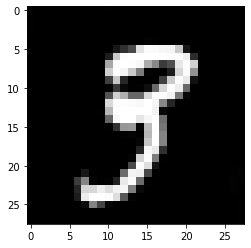

-- Generation 2 --
  Min 68.46311887627598
  Max 205.60127982719223
  Avg 126.56056015638576
  Std 24.96844117306256
(68.46311887627598,)


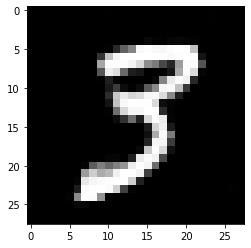

-- Generation 3 --
  Min 67.20395090844613
  Max 189.29467172065415
  Avg 112.98844810548594
  Std 20.5455134886901
(67.20395090844613,)


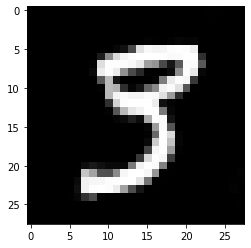

-- Generation 4 --
  Min 67.20395090844613
  Max 179.81200799169983
  Avg 103.65002171985743
  Std 20.778990819762782
(67.20395090844613,)


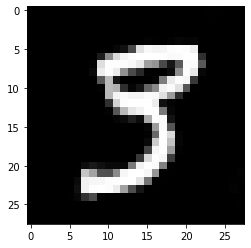

-- Generation 5 --
  Min 63.568189933103895
  Max 150.12902758590735
  Avg 96.22742492566609
  Std 19.74428200175112
(63.568189933103895,)


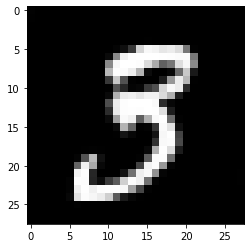

-- Generation 6 --
  Min 44.972915430735384
  Max 152.27296766884683
  Avg 89.730709233155
  Std 20.076912985611376
(44.972915430735384,)


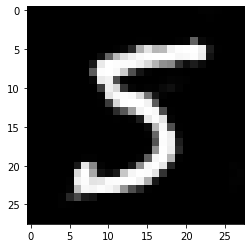

-- Generation 7 --
  Min 36.45168723160532
  Max 150.23984614411893
  Avg 80.87448406075178
  Std 16.706800191496278
(36.45168723160532,)


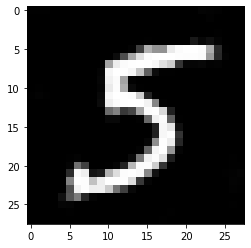

-- Generation 8 --
  Min 36.45168723160532
  Max 141.3836063345807
  Avg 75.49338403968676
  Std 16.691551494250042
(36.45168723160532,)


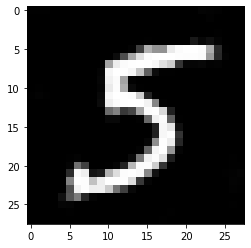

-- Generation 9 --
  Min 36.45168723160532
  Max 170.22766626550947
  Avg 73.11541803101456
  Std 18.50387719602228
(36.45168723160532,)


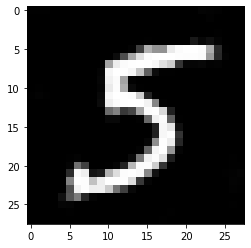

-- Generation 10 --
  Min 31.58915826177781
  Max 113.03232583677527
  Avg 65.54975842941414
  Std 16.425743690102415
(31.58915826177781,)


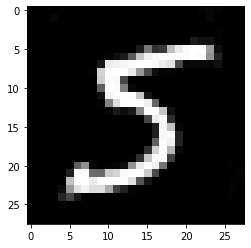

-- Generation 11 --
  Min 34.5769865000932
  Max 125.3246871575393
  Avg 60.095665074905355
  Std 18.779720977540478
(34.5769865000932,)


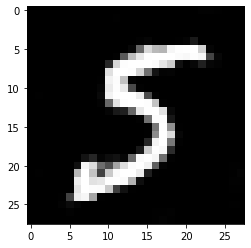

-- Generation 12 --
  Min 34.5769865000932
  Max 106.68655649200082
  Avg 53.539505226418925
  Std 15.438602651814065
(34.5769865000932,)


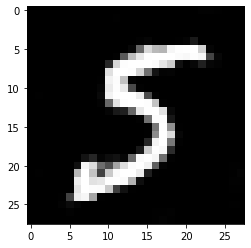

-- Generation 13 --
  Min 28.173472870199475
  Max 160.5794372402679
  Avg 49.90404606345487
  Std 16.809066286832905
(28.173472870199475,)


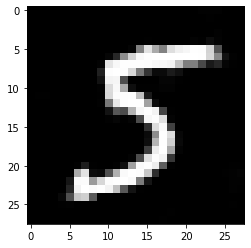

-- Generation 14 --
  Min 29.947294294834137
  Max 105.46681747584898
  Avg 46.340434195689014
  Std 12.359276334109992
(29.947294294834137,)


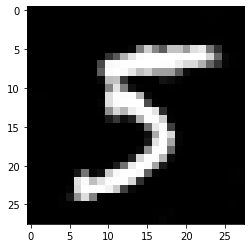

-- Generation 15 --
  Min 25.961306628387547
  Max 89.07007841080485
  Avg 45.92153072159499
  Std 11.78858228886384
(25.961306628387547,)


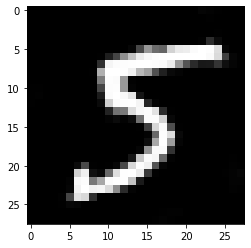

-- Generation 16 --
  Min 25.961306628387547
  Max 102.9682344770199
  Avg 43.80551706052903
  Std 11.57324288478432
(25.961306628387547,)


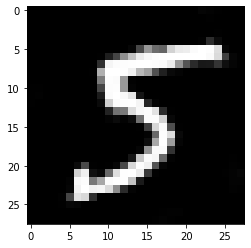

-- Generation 17 --
  Min 25.62564264197499
  Max 95.69479257479543
  Avg 41.969431808074134
  Std 11.471953130123374
(25.62564264197499,)


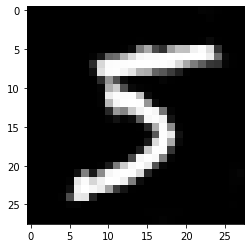

-- Generation 18 --
  Min 25.961306628387547
  Max 80.14080797329461
  Avg 41.860452336207956
  Std 10.475186138597069
(25.961306628387547,)


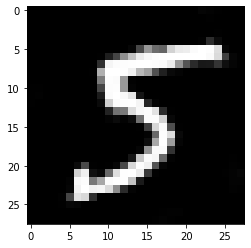

-- Generation 19 --
  Min 25.961306628387547
  Max 77.91873473871328
  Avg 41.03423076158875
  Std 10.85717395725359
(25.961306628387547,)


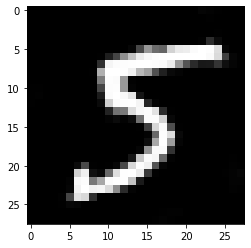

-- Generation 20 --
  Min 24.350210056232754
  Max 81.23398870159235
  Avg 38.59483847856605
  Std 9.878003545514984
(24.350210056232754,)


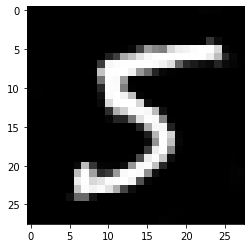

-- Generation 21 --
  Min 25.961306628387547
  Max 87.2272479858666
  Avg 39.20382735535323
  Std 11.332551091649103
(25.961306628387547,)


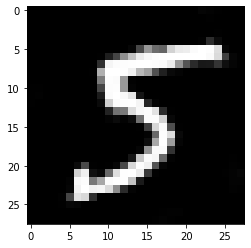

-- Generation 22 --
  Min 24.774005868167478
  Max 68.79610989335924
  Avg 39.055212580980154
  Std 10.60628607994184
(24.774005868167478,)


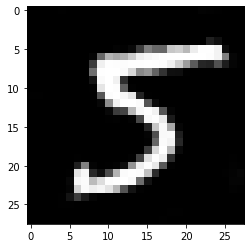

-- Generation 23 --
  Min 25.961306628387547
  Max 70.0474633777958
  Avg 38.00417894335484
  Std 9.778251305415516
(25.961306628387547,)


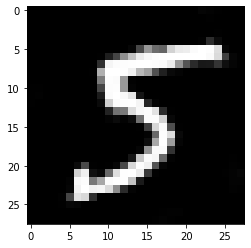

-- Generation 24 --
  Min 25.32722039759392
  Max 63.12964257188378
  Avg 36.1185623007256
  Std 7.7924316484790825
(25.32722039759392,)


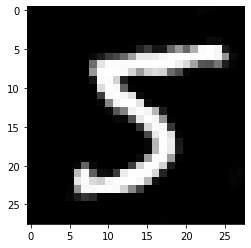

-- Generation 25 --
  Min 25.433274827891182
  Max 64.32205942232395
  Avg 36.98737034030867
  Std 8.21655724543864
(25.433274827891182,)


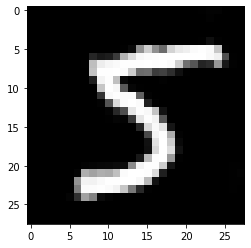

-- Generation 26 --
  Min 25.433274827891182
  Max 130.86975009545222
  Avg 37.97350517555397
  Std 13.90577358749198
(25.433274827891182,)


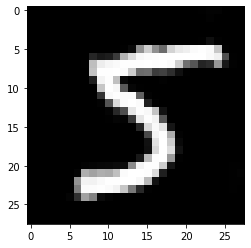

-- Generation 27 --
  Min 24.151351783530345
  Max 77.35541495565849
  Avg 36.06296520202324
  Std 9.910166566633885
(24.151351783530345,)


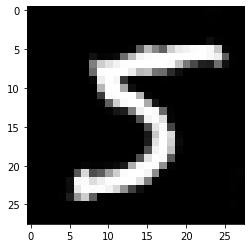

-- Generation 28 --
  Min 24.151351783530345
  Max 74.6577635044232
  Avg 35.017174412800294
  Std 8.63987314905415
(24.151351783530345,)


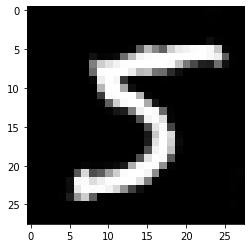

-- Generation 29 --
  Min 24.151351783530345
  Max 70.11353563610464
  Avg 35.21507522925438
  Std 9.567059094589599
(24.151351783530345,)


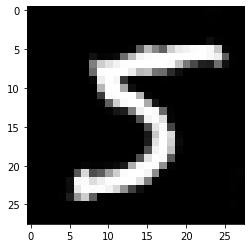

-- Generation 30 --
  Min 23.87331904549592
  Max 72.04674159083879
  Avg 35.23252989205756
  Std 9.065646266096493
(23.87331904549592,)


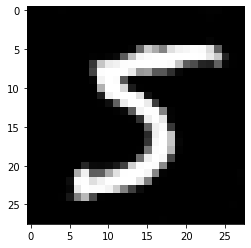

-- Generation 31 --
  Min 23.87331904549592
  Max 112.48434209020706
  Avg 36.67650247172635
  Std 11.933997549998129
(23.87331904549592,)


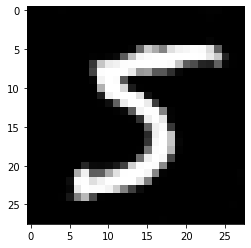

-- Generation 32 --
  Min 23.87331904549592
  Max 113.20670525532114
  Avg 36.71369422195093
  Std 14.278064845690706
(23.87331904549592,)


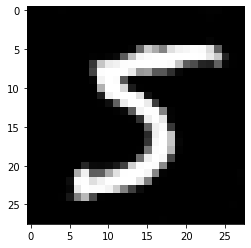

-- Generation 33 --
  Min 22.735507665693376
  Max 84.16104722378441
  Avg 34.78616284792991
  Std 12.043248517087848
(22.735507665693376,)


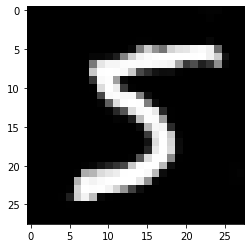

-- Generation 34 --
  Min 23.87331904549592
  Max 57.864836574701485
  Avg 32.32997239931985
  Std 7.064438582244164
(23.87331904549592,)


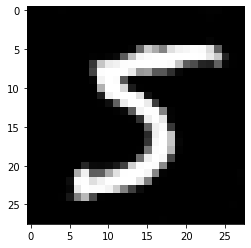

-- Generation 35 --
  Min 23.87331904549592
  Max 116.65186965620615
  Avg 38.25214298427928
  Std 14.395694612230523
(23.87331904549592,)


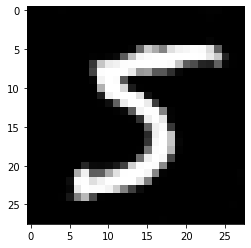

-- Generation 36 --
  Min 23.87331904549592
  Max 76.20624834231512
  Avg 33.722533479064126
  Std 8.614294880837159
(23.87331904549592,)


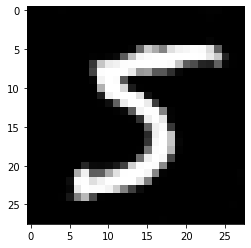

-- Generation 37 --
  Min 23.87331904549592
  Max 73.57992551061125
  Avg 34.38194939888786
  Std 9.677872842237795
(23.87331904549592,)


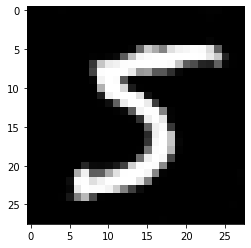

-- Generation 38 --
  Min 23.87331904549592
  Max 99.27728100592503
  Avg 35.45971303195142
  Std 12.440387658040438
(23.87331904549592,)


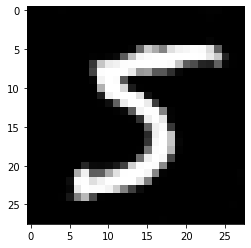

-- Generation 39 --
  Min 23.87331904549592
  Max 164.0966482800295
  Avg 37.35999450590864
  Std 16.716759357654276
(23.87331904549592,)


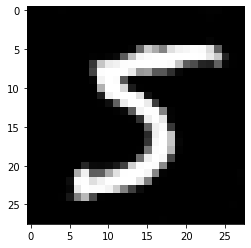

-- Generation 40 --
  Min 24.014547982988915
  Max 66.4703651225218
  Avg 34.18523150722045
  Std 8.967832785786474
(24.014547982988915,)


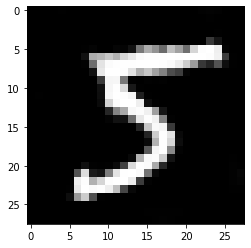

-- Generation 41 --
  Min 24.014547982988915
  Max 103.10720786150432
  Avg 35.294589852024274
  Std 12.817835409539736
(24.014547982988915,)


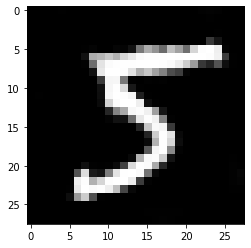

-- Generation 42 --
  Min 24.156362167815132
  Max 72.69583126308953
  Avg 33.504601101812334
  Std 8.433284146883578
(24.156362167815132,)


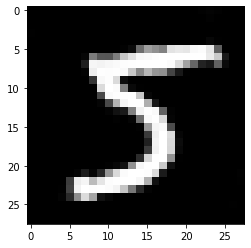

-- Generation 43 --
  Min 23.264815164039646
  Max 65.88825295952938
  Avg 32.32796398466703
  Std 7.942401281760602
(23.264815164039646,)


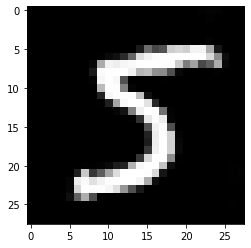

-- Generation 44 --
  Min 23.744671197087882
  Max 71.77973082522294
  Avg 30.809520674084425
  Std 6.572522512297098
(23.744671197087882,)


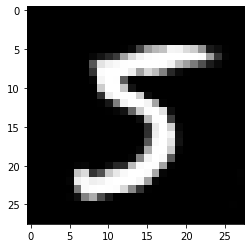

-- Generation 45 --


KeyboardInterrupt: ignored

In [155]:
# For each generation, select the latent vector z* that minimizes fitness, and do the following.
# z = torch.FloatTensor(1, params['nz'], 1, 1).normal_(0, 1)  # torch.Size([100, 1, 1]). This should be z* later on.
output = np.array(main())

z = torch.from_numpy(output).view(1, 100, 1, 1)

gen_image = netG(z)  # torch.Size([1, 28, 28]). This is the generated image that we want to see for each generation.
# Because gen_image should step closer to fgsm_image x for each generation.

print("the shape of generated image : " + str(gen_image.shape))
imshow(gen_image.detach())  # plot the image of generated image

# After GA, give generated image as input to each classifier (use gen_image)

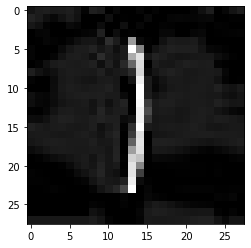

In [122]:
imshow(fgsm_image)  # plot the image of generated image

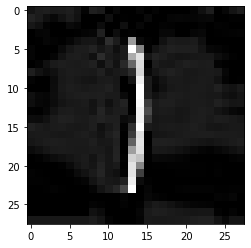

TypeError: ignored

In [127]:
from PIL import Image
import torchvision.transforms.functional as TF
my_image = Image.open(gdrive_root + '/my_data/0.1_1to7.jpg')
my_x = TF.to_tensor(my_image)
imshow(my_x)
print(temp)
print(first_batch[0][0])

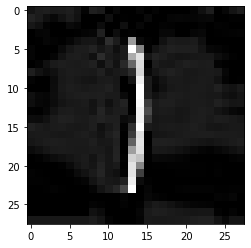

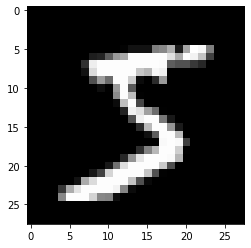

29.276359095831367


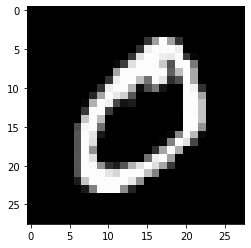

33.19952398201076


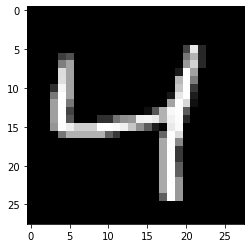

30.214615684995806


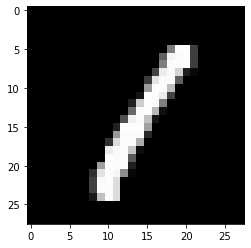

18.451044080848305


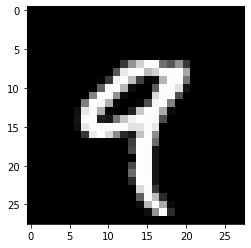

26.413853929562038


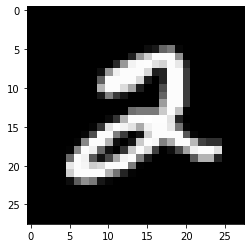

35.508301376147756


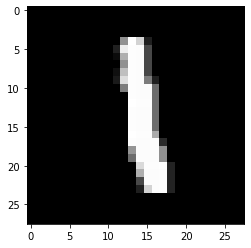

22.717308517199854


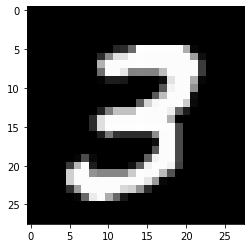

52.75285232804981


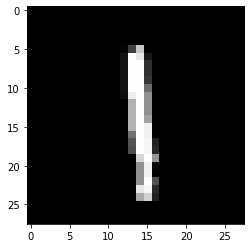

13.484310148112456


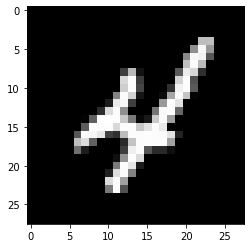

25.00040054481724


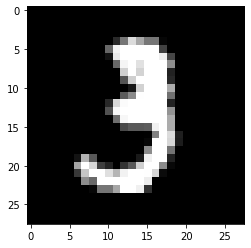

44.48778148743804


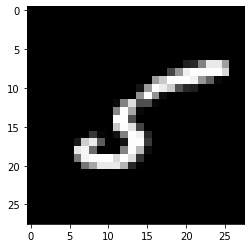

13.200070702601806


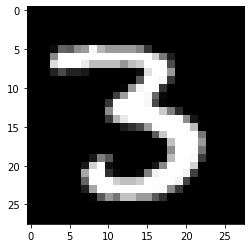

44.76035638094709


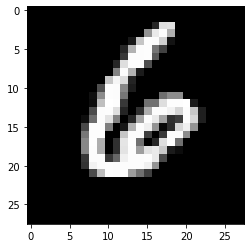

33.75636529631288


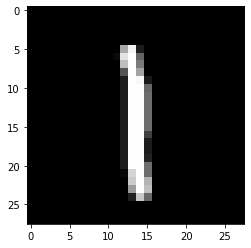

12.078119921792677


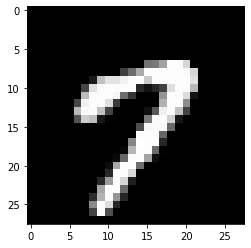

34.10706656544812


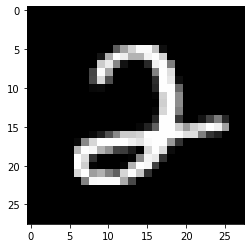

29.399355291392567


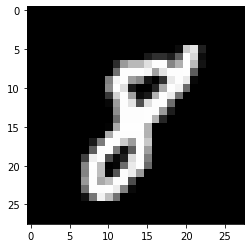

29.836385973267397


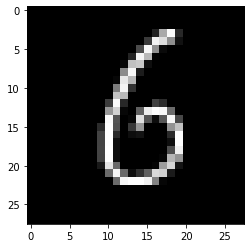

17.049142637875775


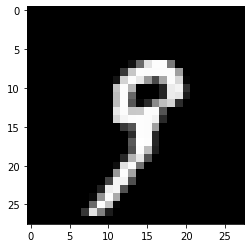

20.270853640286987


In [131]:
from PIL import Image
import torchvision.transforms.functional as TF
my_image = Image.open(gdrive_root + '/my_data/0.1_1to7.jpg')
my_image2 = Image.open(gdrive_root + '/my_data/0.1_2to3.jpg')
my_x = TF.to_tensor(my_image)
my_x2 = TF.to_tensor(my_image2)
imshow(my_x)
#print(x)
#print(np.linalg.norm(my_x.view(28,28).numpy() - my_x2.view(28, 28).numpy(), ord=2)**2)

#print(x)
for i in range(20):
  imshow(first_batch[0][i])
  print(np.linalg.norm(first_batch[0][i].view(28, 28).numpy() - my_x.view(28,28).numpy(), ord=2)**2)